# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 937us/sample - loss: 265.6024 - y1_output_loss: 121.8068 - y2_output_loss: 141.3769 - y1_output_root_mean_squared_error: 11.0883 - y2_output_root_mean_squared_error: 11.9437 - val_loss: 24.3713 - val_y1_output_loss: 9.7224 - val_y2_output_loss: 13.9269 - val_y1_output_root_mean_squared_error: 3.1604 - val_y2_output_root_mean_squared_error: 3.7926
Epoch 2/500
614/614 [==============================] - 0s 155us/sample - loss: 32.0039 - y1_output_loss: 12.5974 - y2_output_loss: 19.2160 - y1_output_root_mean_squared_error: 3.5637 - y2_output_root_mean_squared_error: 4.3936 - val_loss: 19.2196 - val_y1_output_loss: 7.2236 - val_y2_output_loss: 11.4201 - val_y1_output_root_mean_squared_error: 2.7313 - val_y2_output_root_mean_squared_error: 3.4292
Epoch 3/500
614/614 [==============================] - 0s 137us/sample - loss: 25.0020 - y1_output_loss: 10.3427 - y2_output_loss: 14.5699 - y1_o

Epoch 42/500
614/614 [==============================] - 0s 138us/sample - loss: 6.2086 - y1_output_loss: 1.7535 - y2_output_loss: 4.5753 - y1_output_root_mean_squared_error: 1.3251 - y2_output_root_mean_squared_error: 2.1101 - val_loss: 22.3926 - val_y1_output_loss: 4.4405 - val_y2_output_loss: 18.1702 - val_y1_output_root_mean_squared_error: 2.0829 - val_y2_output_root_mean_squared_error: 4.2490
Epoch 43/500
614/614 [==============================] - 0s 136us/sample - loss: 6.8735 - y1_output_loss: 1.8589 - y2_output_loss: 4.9731 - y1_output_root_mean_squared_error: 1.3693 - y2_output_root_mean_squared_error: 2.2358 - val_loss: 4.3910 - val_y1_output_loss: 1.1957 - val_y2_output_loss: 3.0506 - val_y1_output_root_mean_squared_error: 1.1116 - val_y2_output_root_mean_squared_error: 1.7763
Epoch 44/500
614/614 [==============================] - 0s 137us/sample - loss: 9.0773 - y1_output_loss: 2.5995 - y2_output_loss: 6.4146 - y1_output_root_mean_squared_error: 1.6173 - y2_output_root_mean

Epoch 63/500
614/614 [==============================] - 0s 131us/sample - loss: 5.1431 - y1_output_loss: 1.4522 - y2_output_loss: 3.7738 - y1_output_root_mean_squared_error: 1.1951 - y2_output_root_mean_squared_error: 1.9274 - val_loss: 14.6143 - val_y1_output_loss: 5.6098 - val_y2_output_loss: 9.2668 - val_y1_output_root_mean_squared_error: 2.3427 - val_y2_output_root_mean_squared_error: 3.0209
Epoch 64/500
614/614 [==============================] - 0s 135us/sample - loss: 7.2284 - y1_output_loss: 2.0837 - y2_output_loss: 5.1591 - y1_output_root_mean_squared_error: 1.4436 - y2_output_root_mean_squared_error: 2.2681 - val_loss: 4.2392 - val_y1_output_loss: 1.2035 - val_y2_output_loss: 2.9356 - val_y1_output_root_mean_squared_error: 1.1074 - val_y2_output_root_mean_squared_error: 1.7358
Epoch 65/500
614/614 [==============================] - 0s 132us/sample - loss: 4.8841 - y1_output_loss: 1.1595 - y2_output_loss: 3.6934 - y1_output_root_mean_squared_error: 1.0777 - y2_output_root_mean_

Epoch 84/500
614/614 [==============================] - 0s 137us/sample - loss: 3.2202 - y1_output_loss: 0.6934 - y2_output_loss: 2.5148 - y1_output_root_mean_squared_error: 0.8324 - y2_output_root_mean_squared_error: 1.5898 - val_loss: 4.2074 - val_y1_output_loss: 0.8490 - val_y2_output_loss: 3.3113 - val_y1_output_root_mean_squared_error: 0.9185 - val_y2_output_root_mean_squared_error: 1.8340
Epoch 85/500
614/614 [==============================] - 0s 138us/sample - loss: 4.5112 - y1_output_loss: 1.1738 - y2_output_loss: 3.3129 - y1_output_root_mean_squared_error: 1.0854 - y2_output_root_mean_squared_error: 1.8257 - val_loss: 2.6216 - val_y1_output_loss: 0.5573 - val_y2_output_loss: 2.0238 - val_y1_output_root_mean_squared_error: 0.7441 - val_y2_output_root_mean_squared_error: 1.4380
Epoch 86/500
614/614 [==============================] - 0s 132us/sample - loss: 2.7140 - y1_output_loss: 0.5877 - y2_output_loss: 2.1091 - y1_output_root_mean_squared_error: 0.7692 - y2_output_root_mean_s

Epoch 105/500
614/614 [==============================] - 0s 138us/sample - loss: 3.5140 - y1_output_loss: 0.8486 - y2_output_loss: 2.6593 - y1_output_root_mean_squared_error: 0.9140 - y2_output_root_mean_squared_error: 1.6366 - val_loss: 2.3810 - val_y1_output_loss: 0.6037 - val_y2_output_loss: 1.6998 - val_y1_output_root_mean_squared_error: 0.7854 - val_y2_output_root_mean_squared_error: 1.3282
Epoch 106/500
614/614 [==============================] - 0s 140us/sample - loss: 2.6042 - y1_output_loss: 0.5944 - y2_output_loss: 1.9974 - y1_output_root_mean_squared_error: 0.7688 - y2_output_root_mean_squared_error: 1.4188 - val_loss: 3.1212 - val_y1_output_loss: 0.5660 - val_y2_output_loss: 2.4881 - val_y1_output_root_mean_squared_error: 0.7573 - val_y2_output_root_mean_squared_error: 1.5962
Epoch 107/500
614/614 [==============================] - 0s 139us/sample - loss: 2.9262 - y1_output_loss: 0.5494 - y2_output_loss: 2.3917 - y1_output_root_mean_squared_error: 0.7422 - y2_output_root_mea

Epoch 146/500
614/614 [==============================] - 0s 138us/sample - loss: 1.8759 - y1_output_loss: 0.3908 - y2_output_loss: 1.4867 - y1_output_root_mean_squared_error: 0.6255 - y2_output_root_mean_squared_error: 1.2185 - val_loss: 3.1019 - val_y1_output_loss: 0.2956 - val_y2_output_loss: 2.7596 - val_y1_output_root_mean_squared_error: 0.5487 - val_y2_output_root_mean_squared_error: 1.6736
Epoch 147/500
614/614 [==============================] - 0s 134us/sample - loss: 2.6256 - y1_output_loss: 0.5447 - y2_output_loss: 2.0789 - y1_output_root_mean_squared_error: 0.7403 - y2_output_root_mean_squared_error: 1.4414 - val_loss: 2.0001 - val_y1_output_loss: 0.4059 - val_y2_output_loss: 1.5419 - val_y1_output_root_mean_squared_error: 0.6453 - val_y2_output_root_mean_squared_error: 1.2584
Epoch 148/500
614/614 [==============================] - 0s 132us/sample - loss: 2.7111 - y1_output_loss: 0.5947 - y2_output_loss: 2.0954 - y1_output_root_mean_squared_error: 0.7744 - y2_output_root_mea

Epoch 187/500
614/614 [==============================] - 0s 152us/sample - loss: 1.6386 - y1_output_loss: 0.2720 - y2_output_loss: 1.3856 - y1_output_root_mean_squared_error: 0.5205 - y2_output_root_mean_squared_error: 1.1695 - val_loss: 1.8404 - val_y1_output_loss: 0.2504 - val_y2_output_loss: 1.5338 - val_y1_output_root_mean_squared_error: 0.5071 - val_y2_output_root_mean_squared_error: 1.2583
Epoch 188/500
614/614 [==============================] - 0s 136us/sample - loss: 1.7228 - y1_output_loss: 0.3627 - y2_output_loss: 1.3646 - y1_output_root_mean_squared_error: 0.6050 - y2_output_root_mean_squared_error: 1.1648 - val_loss: 2.3028 - val_y1_output_loss: 0.2346 - val_y2_output_loss: 2.0544 - val_y1_output_root_mean_squared_error: 0.4830 - val_y2_output_root_mean_squared_error: 1.4386
Epoch 189/500
614/614 [==============================] - 0s 134us/sample - loss: 1.5135 - y1_output_loss: 0.2776 - y2_output_loss: 1.2266 - y1_output_root_mean_squared_error: 0.5260 - y2_output_root_mea

Epoch 228/500
614/614 [==============================] - 0s 132us/sample - loss: 1.2209 - y1_output_loss: 0.2396 - y2_output_loss: 0.9796 - y1_output_root_mean_squared_error: 0.4916 - y2_output_root_mean_squared_error: 0.9896 - val_loss: 1.2569 - val_y1_output_loss: 0.2275 - val_y2_output_loss: 0.9865 - val_y1_output_root_mean_squared_error: 0.4826 - val_y2_output_root_mean_squared_error: 1.0119
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0681 - y1_output_loss: 0.2135 - y2_output_loss: 0.8462 - y1_output_root_mean_squared_error: 0.4631 - y2_output_root_mean_squared_error: 0.9239 - val_loss: 1.1694 - val_y1_output_loss: 0.2752 - val_y2_output_loss: 0.8710 - val_y1_output_root_mean_squared_error: 0.5197 - val_y2_output_root_mean_squared_error: 0.9483
Epoch 230/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3596 - y1_output_loss: 0.2884 - y2_output_loss: 1.0593 - y1_output_root_mean_squared_error: 0.5396 - y2_output_root_mea

Epoch 269/500
614/614 [==============================] - 0s 135us/sample - loss: 1.9974 - y1_output_loss: 0.5193 - y2_output_loss: 1.4847 - y1_output_root_mean_squared_error: 0.7175 - y2_output_root_mean_squared_error: 1.2176 - val_loss: 3.8615 - val_y1_output_loss: 1.2981 - val_y2_output_loss: 2.6190 - val_y1_output_root_mean_squared_error: 1.1223 - val_y2_output_root_mean_squared_error: 1.6131
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9957 - y1_output_loss: 0.2131 - y2_output_loss: 0.7833 - y1_output_root_mean_squared_error: 0.4617 - y2_output_root_mean_squared_error: 0.8846 - val_loss: 3.6967 - val_y1_output_loss: 1.2118 - val_y2_output_loss: 2.5935 - val_y1_output_root_mean_squared_error: 1.0734 - val_y2_output_root_mean_squared_error: 1.5952
Epoch 271/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0382 - y1_output_loss: 0.2579 - y2_output_loss: 0.7720 - y1_output_root_mean_squared_error: 0.5102 - y2_output_root_mea

Epoch 310/500
614/614 [==============================] - 0s 138us/sample - loss: 0.7883 - y1_output_loss: 0.1748 - y2_output_loss: 0.6075 - y1_output_root_mean_squared_error: 0.4192 - y2_output_root_mean_squared_error: 0.7827 - val_loss: 0.9630 - val_y1_output_loss: 0.1827 - val_y2_output_loss: 0.7495 - val_y1_output_root_mean_squared_error: 0.4337 - val_y2_output_root_mean_squared_error: 0.8803
Epoch 311/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7020 - y1_output_loss: 0.1626 - y2_output_loss: 0.5360 - y1_output_root_mean_squared_error: 0.4030 - y2_output_root_mean_squared_error: 0.7346 - val_loss: 1.0436 - val_y1_output_loss: 0.1684 - val_y2_output_loss: 0.8512 - val_y1_output_root_mean_squared_error: 0.4168 - val_y2_output_root_mean_squared_error: 0.9327
Epoch 312/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8779 - y1_output_loss: 0.1851 - y2_output_loss: 0.6949 - y1_output_root_mean_squared_error: 0.4313 - y2_output_root_mea

Epoch 351/500
614/614 [==============================] - 0s 134us/sample - loss: 1.0594 - y1_output_loss: 0.2327 - y2_output_loss: 0.8187 - y1_output_root_mean_squared_error: 0.4824 - y2_output_root_mean_squared_error: 0.9092 - val_loss: 0.9636 - val_y1_output_loss: 0.2646 - val_y2_output_loss: 0.6676 - val_y1_output_root_mean_squared_error: 0.5238 - val_y2_output_root_mean_squared_error: 0.8302
Epoch 352/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6610 - y1_output_loss: 0.1594 - y2_output_loss: 0.4970 - y1_output_root_mean_squared_error: 0.3994 - y2_output_root_mean_squared_error: 0.7082 - val_loss: 0.9733 - val_y1_output_loss: 0.2661 - val_y2_output_loss: 0.6787 - val_y1_output_root_mean_squared_error: 0.5223 - val_y2_output_root_mean_squared_error: 0.8370
Epoch 353/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6621 - y1_output_loss: 0.1492 - y2_output_loss: 0.5078 - y1_output_root_mean_squared_error: 0.3867 - y2_output_root_mea

Epoch 392/500
614/614 [==============================] - 0s 134us/sample - loss: 0.6389 - y1_output_loss: 0.1435 - y2_output_loss: 0.4941 - y1_output_root_mean_squared_error: 0.3789 - y2_output_root_mean_squared_error: 0.7038 - val_loss: 0.7470 - val_y1_output_loss: 0.1655 - val_y2_output_loss: 0.5582 - val_y1_output_root_mean_squared_error: 0.4115 - val_y2_output_root_mean_squared_error: 0.7600
Epoch 393/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8990 - y1_output_loss: 0.2120 - y2_output_loss: 0.6816 - y1_output_root_mean_squared_error: 0.4608 - y2_output_root_mean_squared_error: 0.8287 - val_loss: 0.8251 - val_y1_output_loss: 0.1925 - val_y2_output_loss: 0.6031 - val_y1_output_root_mean_squared_error: 0.4456 - val_y2_output_root_mean_squared_error: 0.7915
Epoch 394/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4862 - y1_output_loss: 0.1299 - y2_output_loss: 0.3568 - y1_output_root_mean_squared_error: 0.3601 - y2_output_root_mea

Epoch 433/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5664 - y1_output_loss: 0.1377 - y2_output_loss: 0.4236 - y1_output_root_mean_squared_error: 0.3726 - y2_output_root_mean_squared_error: 0.6539 - val_loss: 0.6547 - val_y1_output_loss: 0.1577 - val_y2_output_loss: 0.4830 - val_y1_output_root_mean_squared_error: 0.3970 - val_y2_output_root_mean_squared_error: 0.7050
Epoch 434/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4247 - y1_output_loss: 0.1366 - y2_output_loss: 0.2892 - y1_output_root_mean_squared_error: 0.3710 - y2_output_root_mean_squared_error: 0.5358 - val_loss: 1.2912 - val_y1_output_loss: 0.1969 - val_y2_output_loss: 1.0597 - val_y1_output_root_mean_squared_error: 0.4516 - val_y2_output_root_mean_squared_error: 1.0427
Epoch 435/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5132 - y1_output_loss: 0.1341 - y2_output_loss: 0.3807 - y1_output_root_mean_squared_error: 0.3640 - y2_output_root_mea

Epoch 474/500
614/614 [==============================] - 0s 140us/sample - loss: 0.5553 - y1_output_loss: 0.1499 - y2_output_loss: 0.4016 - y1_output_root_mean_squared_error: 0.3879 - y2_output_root_mean_squared_error: 0.6363 - val_loss: 0.8825 - val_y1_output_loss: 0.1846 - val_y2_output_loss: 0.6750 - val_y1_output_root_mean_squared_error: 0.4361 - val_y2_output_root_mean_squared_error: 0.8320
Epoch 475/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4006 - y1_output_loss: 0.1154 - y2_output_loss: 0.2827 - y1_output_root_mean_squared_error: 0.3404 - y2_output_root_mean_squared_error: 0.5336 - val_loss: 0.8571 - val_y1_output_loss: 0.2242 - val_y2_output_loss: 0.6073 - val_y1_output_root_mean_squared_error: 0.4812 - val_y2_output_root_mean_squared_error: 0.7910
Epoch 476/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3545 - y1_output_loss: 0.1085 - y2_output_loss: 0.2438 - y1_output_root_mean_squared_error: 0.3298 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 33us/sample - loss: 0.7541 - y1_output_loss: 0.2505 - y2_output_loss: 0.4996 - y1_output_root_mean_squared_error: 0.5051 - y2_output_root_mean_squared_error: 0.7064
Loss = 0.7540796135927176, Y1_loss = 0.25047314167022705, Y1_mse = 0.5050889849662781, Y2_loss = 0.49956947565078735, Y2_mse = 0.7063744068145752


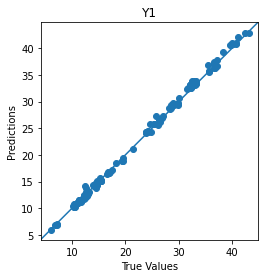

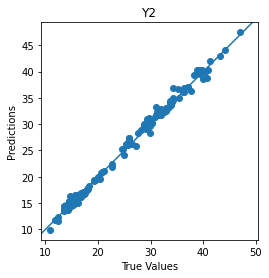

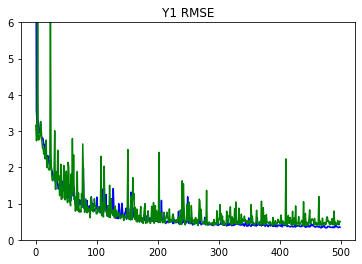

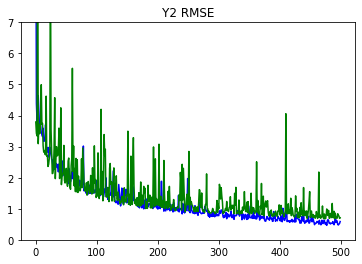

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)